In [70]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

In [71]:
data = {
        'random_number': [124, 248, 496, 992],
        'geometry': [Point(24.945831, 60.192059), Point(24.6559, 60.2055),
                     Point(25.0378, 60.2934), Point(24.7284, 60.2124)]
    }

gdf = gpd.GeoDataFrame(data)

In [78]:
def distance_matrix(x0, y0, x1, y1):
    d0 = np.subtract.outer(x0, x1)
    d1 = np.subtract.outer(y0, y1)
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=2):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    dist = distance_matrix(x, y, xi, yi)

    # Add a small epsilon to avoid division by zero
    dist = np.where(dist == 0, 1e-12, dist)

    # In IDW, weights are 1 / (distance ^ power)
    weights = 1.0 / (dist**power)

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


def idw_interpolation_geodataframe(geodataframe, target_column, output_resolution=(50, 50), extent=None, power=1):
    points = np.array(geodataframe.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())
    values = geodataframe[target_column].values

    if extent is None:
        x_min = geodataframe.geometry.total_bounds[0]
        x_max = geodataframe.geometry.total_bounds[2]
        y_min = geodataframe.geometry.total_bounds[1]
        y_max = geodataframe.geometry.total_bounds[3]
    else:
        x_min, y_min, x_max, y_max = extent

    resolution_x, resolution_y = output_resolution

    num_points_x = int((x_max - x_min) / resolution_x) + 1
    num_points_y = int((y_max - y_min) / resolution_y) + 1

    x = np.linspace(x_min, x_max, num_points_x)
    y = np.linspace(y_min, y_max, num_points_y)

    xi, yi = np.meshgrid(x, y)
    xi = xi.flatten()
    yi = yi[::-1].flatten()  # Reverse the order of y-values

    origin_x, origin_y = 0, 0
    dist_from_origin = np.hypot(points[:, 0] - origin_x, points[:, 1] - origin_y)
    sorted_indices = np.argsort(dist_from_origin)
    sorted_points = points[sorted_indices]
    sorted_values = values[sorted_indices]

    interpolated_values = simple_idw(sorted_points[:, 0], sorted_points[:, 1], sorted_values, xi, yi, power)
    interpolated_values = interpolated_values.reshape(num_points_y, num_points_x)

    return x, y, interpolated_values

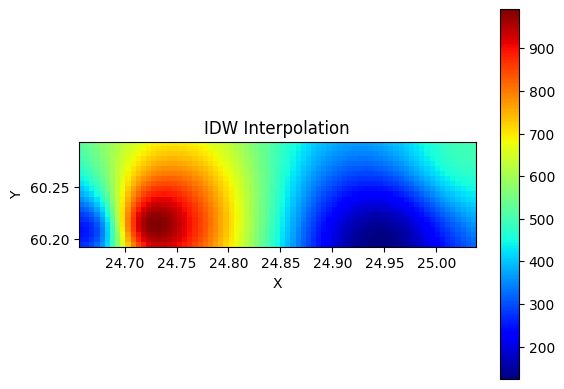

In [81]:
x, y, interpolated_values = idw_interpolation_geodataframe(
    geodataframe=gdf,
    target_column='random_number',
    output_resolution=(0.005, 0.005),
    #extent=(24.655899, 60.192059, 25.037803604, 60.293407876),
    extent=None,
    power=2
)

# Plot the interpolated values
plt.imshow(interpolated_values, cmap='jet', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('IDW Interpolation')
plt.show()